# Image Segmentation for Self Driving Car



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image # Image loading and editing
import cv2 # Image processing
from sklearn.cluster import KMeans # For color clustering
import random
import matplotlib.pyplot as plt

# high level interface to tensorflow
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [3]:
# Train and Validation image path
train_img_path = "/content/drive/MyDrive/Colab Notebooks/Final Train"
val_img_path ="/content/drive/MyDrive/Colab Notebooks/Final Val"

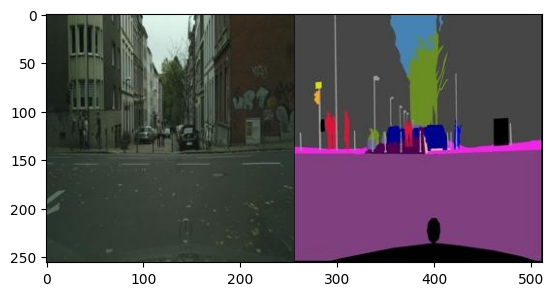

In [4]:
# Read a sample image
name = '10.jpg'
input_img = Image.open(train_img_path+"/"+name)
plot.imshow(input_img)

### Crop the image into the actual image and segmentation

In [5]:
print(input_img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x256 at 0x7E87B7C5ABF0>


Text(0.5, 1.0, 'Segmentation')

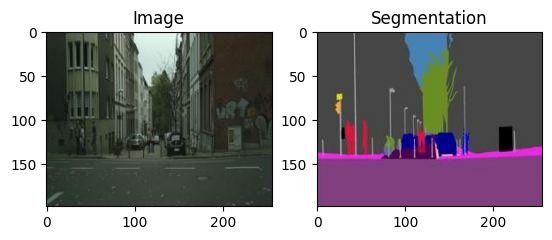

In [6]:
cut_bottom = 58

# Convert image into np array
input_img = np.array(input_img)

# Crop the segmentation from the image
segmt = input_img[:-cut_bottom, 256:] # segment
input_img = input_img[:-cut_bottom, 0:256]

# Plot the Image and segmentation
f, ax = plot.subplots(nrows=1,ncols=2)
ax[0].imshow(input_img)
ax[0].set_title('Image')
ax[1].imshow(segmt)
ax[1].set_title('Segmentation')


### Perform histogram equalization



Text(0.5, 1.0, 'Processed')

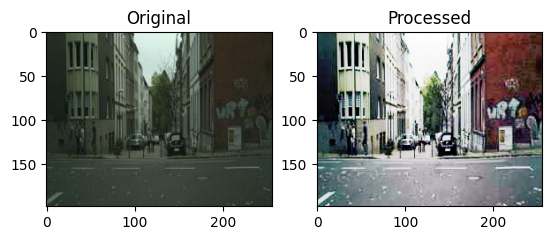

In [7]:
orig_input_img = input_img.copy()

for i in range(3): # for 3 colour channels of the image (RGB)
    zinput_img = input_img[:,:,i] #It takes the ith colour(RGB)
    zinput_img = cv2.equalizeHist(zinput_img) #This line applies histogram equalization to the extracted color channel using the OpenCV function equalizeHist().
    #Histogram equalization enhances the contrast of the image by spreading out the intensity values across the histogram.
    input_img[:,:,i] = zinput_img

# Plot the Image and segmentation
f, ax = plot.subplots(nrows=1,ncols=2)
ax[0].imshow(orig_input_img)
ax[0].set_title('Original')
ax[1].imshow(input_img)
ax[1].set_title('Processed')

### RESIZING

In [8]:
# Resize
size = (256, 200) #does not effect the RGB dimension
input_img = Image.fromarray(input_img).resize(size)
segmt = Image.fromarray(segmt).resize(size)

input_img = (np.array(input_img))/255  # scales RGB values to range [0,1]
segmt = (np.array(segmt))/255

# using Image.fromarray() to convert the numpy array to a PIL Image object, then resizes it to the specified size using the resize()
#the last two lines converts image back to numpy array.

### Create function for doing the above operations for all images


In [9]:
def load_image(name, path=train_img_path,
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):

    # Read the image
    input_img = Image.open(path+"/"+name)
    # Convert image into np array
    input_img = np.array(input_img)
    segmt = input_img[:-cut_bottom, 256:] # segment
    input_img = input_img[:-cut_bottom, 0:256]

    for i in range(3): # for 3 colour channels of the image
        zinput_img = input_img[:,:,i]
        zinput_img = cv2.equalizeHist(zinput_img)
        input_img[:,:,i] = zinput_img

    # Resize
    input_img = Image.fromarray(input_img).resize(size)
    segmt = Image.fromarray(segmt).resize(size)

    # Rotation
    input_img = input_img.rotate(rotation)
    segmt = segmt.rotate(rotation)

    input_img = np.array(input_img)
    segmt = np.array(segmt)

    # If flip bool is True
    if flip:
        input_img = input_img[:,::-1,:] #flips the image(mirror image) if required
        segmt = segmt[:,::-1,:]

    return input_img/255, segmt/255

In [10]:
# load image and segment
input_img, segmt = load_image("100.jpg")

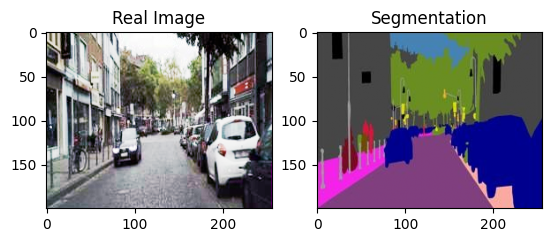

In [11]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(input_img)
axs[0].set_title('Real Image')

axs[1].imshow(segmt)
axs[1].set_title('Segmentation')

# Show the plot
plt.show()

## Color Clustering


In [12]:
# List the directories under train
train_files = os.listdir(train_img_path)[0:10]  # selects the first 10 images in train_file

get_colors = []
for file in train_files:
    input_img, segmt = load_image(file)
    get_colors.append(segmt.reshape(segmt.shape[0]*segmt.shape[1], 3)) # it converts the segmt image to 2D,-
    #such that each row represents a single pixel with 3 columns that indicates RGB value

# convert to numpy array
get_colors = np.array(get_colors)
get_colors = get_colors.reshape((get_colors.shape[0]*get_colors.shape[1],3)) # joins all 10 image get_colors array as one.

In [13]:
# Initializing a KMeans clustering module for 13 classes of colours
km = KMeans(13)
# Fittig the value of
km.fit(get_colors)
# It uses the get_colour array and clusters it to 13 different clusters depending on similar colour(similar coloured pixels gets clustered)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=13)

## Converting discrete color representation to class representation



In [14]:
def Colors2Class(segmt):
    s = segmt.reshape((segmt.shape[0]*segmt.shape[1],3))
    s = km.predict(s)
    s = s.reshape((segmt.shape[0], segmt.shape[1])) # reshaping 's' to original segmnt size (now its an array of cluster no. instead of pixel value)

    n = len(km.cluster_centers_)

    cls = np.zeros((segmt.shape[0], segmt.shape[1], n)) #creating a new array with 3 dimensions (3rd dimension is no. of cluster_centres)

    for i in range(n): #for each cluster_centre
        m = np.copy(s)
        m[m!=i] = 0 #assigns 0 to all value in array m that is not equal to i
        m[m!=0] = 1 #after that, assigns 1 to all value in array m that was not given 0

        cls[:,:,i]=m # defines the array for each cluster centre

    return cls


In [15]:
segmt2 = Colors2Class(segmt)

## Convert Layers to RGB Image

computer displays can only utilize the RGB colorspace. This function converts the layer representation to a color representation. This is just for visualizing.

In [16]:
def Layers2RGBImage(input_img):  #input_img == our 3D array with third dimension being no. of cluster head with (0,1) values, the one from previous cell
    colors_lst = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)] # no. tuples = no. of clusters

    num_img = np.zeros((input_img.shape[0], input_img.shape[1], 3))
    for i in range(input_img.shape[2]):
        c = input_img[:,:,i]
        col = colors_lst[i]

        for j in range(3):
            num_img[:,:,j]+=col[j]*c
    num_img = num_img/255.0
    return num_img  # final RGB image array

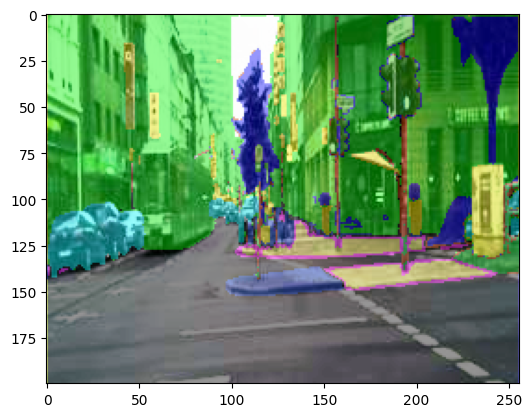

In [17]:
segmt2 = Layers2RGBImage(segmt2)
total = cv2.addWeighted(input_img, 0.6, segmt2, 0.4, 0)
plot.imshow(total[:,:,:]) # display the image
plot.show()

## DATA AUGMENTATION & Create a function to generate data as a list

here we take batch of 10 images from Train_file at a time and does Data augmentation (by flipping random images and random angles) to get a better dataset for training CNN.

Then we append the next 10 images to the list and so on...

In [18]:
def generate_data(img_path=train_img_path, batch_size=10,
            maxangle=10.0):

    files = os.listdir(img_path)
    while True:
        input_img_list=[]
        segmt_list=[]

        for i in range(batch_size):
            image_file = random.sample(files,1)[0]

            flip=False
            if random.random() > 0.5:
                flip=True

            angle = maxangle*(random.random()*2-1)

            input_img, segmt = load_image(image_file, img_path, rotation=angle, flip=flip)

            segmt = Colors2Class(segmt)

            input_img_list.append(input_img)
            segmt_list.append(segmt)
        yield np.array(input_img_list), np.array(segmt_list)


In [19]:
generated_data = generate_data()
input_img_list, segmt_list = next(generated_data)

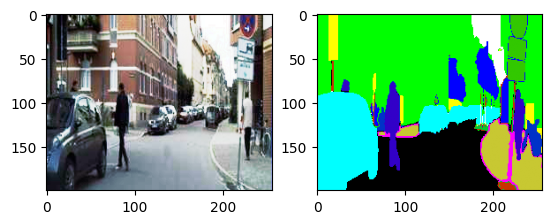

In [20]:
plot.subplot(121)
plot.imshow(input_img_list[0])
plot.subplot(122)
plot.imshow(Layers2RGBImage(segmt_list[0]))
plot.show()

### Generating training and validation Dataset using the above function

In [21]:
# Training generator
train_generator = generate_data()

# Validation generator
val_generator = generate_data(val_img_path)

## Building the Convolutional Neural Network - UNet



####Encoder Layers:

Conv2D layers with decreasing kernel sizes are present in the encoder part. These layers learn hierarchical features.
There are four sets of convolutional layers in the encoder, each followed by a MaxPooling2D layer for downsampling.
So, there are a total of 8 convolutional layers in the encoder.

####Decoder Layers:

Conv2D layers followed by UpSampling2D and concatenation layers constitute the decoder part.
There are three sets of convolutional layers in the decoder, each followed by an UpSampling2D layer and concatenation with the corresponding encoder layer.
So, there are a total of 6 convolutional layers in the decoder.

####Output Layer:

There's an additional pair of Conv2D layers at the end to produce the output.
So, there are 2 convolutional layers in the output part.

Adding up the encoder, decoder, and output layers, the total number of U-Net layers in this architecture is 8+6+2=16.

In [22]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 256, 3)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 200, 256, 3)          12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 200, 256, 64)         27712     ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 256, 128)        1179776   ['conv2d[0][0]']          

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, UpSampling2D, Activation, Multiply, Reshape
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def spatial_attention(input_feature):
    # Compute channel-wise average pooling to obtain attention weights
    attention = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(input_feature)

    # Apply attention to the input feature maps
    return Multiply()([input_feature, attention])

# Define the U-Net architecture
inp = Input(shape=(200, 256, 3))

# Use VGG16 as a feature extractor for the encoder part
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
for layer in vgg16.layers:
    layer.trainable = False

# Encoder part
encoder_outputs = [vgg16.get_layer(layer_name).output for layer_name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']]
encoder = Model(inputs=vgg16.input, outputs=encoder_outputs)

# Decoder part
x1, x2, x3, x4 = encoder.output

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(256, 3, activation="relu", padding="same")(x5)
x5 = Conv2D(256, 3, activation="relu", padding="same")(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 3, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 3, activation="relu", padding="same")(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(64, 3, activation="relu", padding="same")(x7)
x7 = Conv2D(64, 3, activation="relu", padding="same")(x7)

x8 = Conv2D(1, 1, activation="sigmoid")(x7)

model2 = Model(inputs=inp, outputs=x8)

opt = Adam(lr=0.0001)
model2.compile(optimizer=opt,
             loss="binary_crossentropy",
             metrics=["accuracy"])
model2.summary()


58889256/58889256 [==============================] - 0s 0us/step


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

The network has 9 million trainable parameters.

## Training the model

Finally we can start training. We will train for 1000 epochs and use a Model Checkpoint to save the model with the smallest validation loss.

In [24]:
saved_callback = [ModelCheckpoint("model_loss_1.h5", save_best_only=True, verbose=0)]

model_history = model.fit(train_generator, epochs=25, steps_per_epoch=10,
                       validation_data=val_generator, validation_steps=10,
                       callbacks=saved_callback)

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 145.3488 - accuracy: 0.1720

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 97s 5s/step - loss: 145.3488 - accuracy: 0.1720 - val_loss: 1.6089 - val_accuracy: 0.1690
Epoch 2/25
10/10 [==============================] - 15s 2s/step - loss: 1.6280 - accuracy: 0.2429 - val_loss: 1.6255 - val_accuracy: 0.2396
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 1.5716 - accuracy: 0.2506

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 18s 2s/step - loss: 1.5716 - accuracy: 0.2506 - val_loss: 1.5326 - val_accuracy: 0.2430
Epoch 4/25
10/10 [==============================] - 16s 2s/step - loss: 1.5387 - accuracy: 0.2378 - val_loss: 1.5768 - val_accuracy: 0.2625
Epoch 5/25
10/10 [==============================] - 17s 2s/step - loss: 3.1261 - accuracy: 0.2031 - val_loss: 39.8236 - val_accuracy: 0.0488
Epoch 6/25
10/10 [==============================] - 17s 2s/step - loss: 16628.0527 - accuracy: 0.1065 - val_loss: 107974.7109 - val_accuracy: 0.2242
Epoch 7/25
10/10 [==============================] - 17s 2s/step - loss: 43080.6562 - accuracy: 0.0981 - val_loss: 1885.1394 - val_accuracy: 0.1753
Epoch 8/25
10/10 [==============================] - 17s 2s/step - loss: 281.4378 - accuracy: 0.1817 - val_loss: 1.7467 - val_accuracy: 0.0295
Epoch 9/25
10/10 [==============================] - 17s 2s/step - loss: 1.8555 - accuracy: 0.0936 - val_loss: 1.7814 - val_accuracy: 0.0243
Epoch 10/25


In [26]:
saved_callback2 = [ModelCheckpoint("model_loss_2.h5", save_best_only=True, verbose=0)]

model_history2 = model2.fit(train_generator, epochs=25, steps_per_epoch=10,
                       validation_data=val_generator, validation_steps=10,
                       callbacks=saved_callback2)

Epoch 1/25
10/10 [==============================] - 24s 746ms/step - loss: 1.0235 - accuracy: 0.9385 - val_loss: 0.2357 - val_accuracy: 0.9416
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 6s 606ms/step - loss: 0.2293 - accuracy: 0.9409 - val_loss: 0.2209 - val_accuracy: 0.9422
Epoch 3/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 8s 863ms/step - loss: 0.2275 - accuracy: 0.9403 - val_loss: 0.2231 - val_accuracy: 0.9406
Epoch 4/25
10/10 [==============================] - 6s 596ms/step - loss: 0.2250 - accuracy: 0.9404 - val_loss: 0.2216 - val_accuracy: 0.9410
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9403

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 8s 881ms/step - loss: 0.2226 - accuracy: 0.9403 - val_loss: 0.2199 - val_accuracy: 0.9407
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 6s 641ms/step - loss: 0.2215 - accuracy: 0.9400 - val_loss: 0.2182 - val_accuracy: 0.9409
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9402

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 8s 879ms/step - loss: 0.2202 - accuracy: 0.9402 - val_loss: 0.2165 - val_accuracy: 0.9409
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9407

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 8s 880ms/step - loss: 0.2176 - accuracy: 0.9407 - val_loss: 0.2160 - val_accuracy: 0.9409
Epoch 9/25
10/10 [==============================] - 6s 641ms/step - loss: 0.2190 - accuracy: 0.9400 - val_loss: 0.2102 - val_accuracy: 0.9424
Epoch 10/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 8s 849ms/step - loss: 0.2183 - accuracy: 0.9401 - val_loss: 0.2165 - val_accuracy: 0.9406
Epoch 11/25
10/10 [==============================] - 6s 582ms/step - loss: 0.2176 - accuracy: 0.9403 - val_loss: 0.2111 - val_accuracy: 0.9421
Epoch 12/25
10/10 [==============================] - 6s 652ms/step - loss: 0.2155 - accuracy: 0.9411 - val_loss: 0.2143 - val_accuracy: 0.9414
Epoch 13/25
10/10 [==============================] - 8s 869ms/step - loss: 0.2186 - accuracy: 0.9401 - val_loss: 0.2132 - val_accuracy: 0.9415
Epoch 14/25
10/10 [==============================] - 6s 668ms/step - loss: 0.2133 - accuracy: 0.9413 - val_loss: 0.2164 - val_accuracy: 0.9408
Epoch 15/25
10/10 [==============================] - 6s 606ms/step - loss: 0.2164 - accuracy: 0.9407 - val_loss: 0.2123 - val_accuracy: 0.9417
Epoch 16/25
10/10 [==============================] - 6s 601ms/step - loss: 0.2192 - accuracy: 0.9403 - val_loss: 0.2151 - val_accuracy: 0.9410
Epoch 17/25

Time to save the model and load the best model from the training run.

In [25]:
model.save("trained_model_1.h5")
model = load_model("model_loss_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
model2.save("trained_model_2.h5")
model2 = load_model("model_loss_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ACCURACY AND LOSS GRAPH (Simple U-Net)

In [28]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

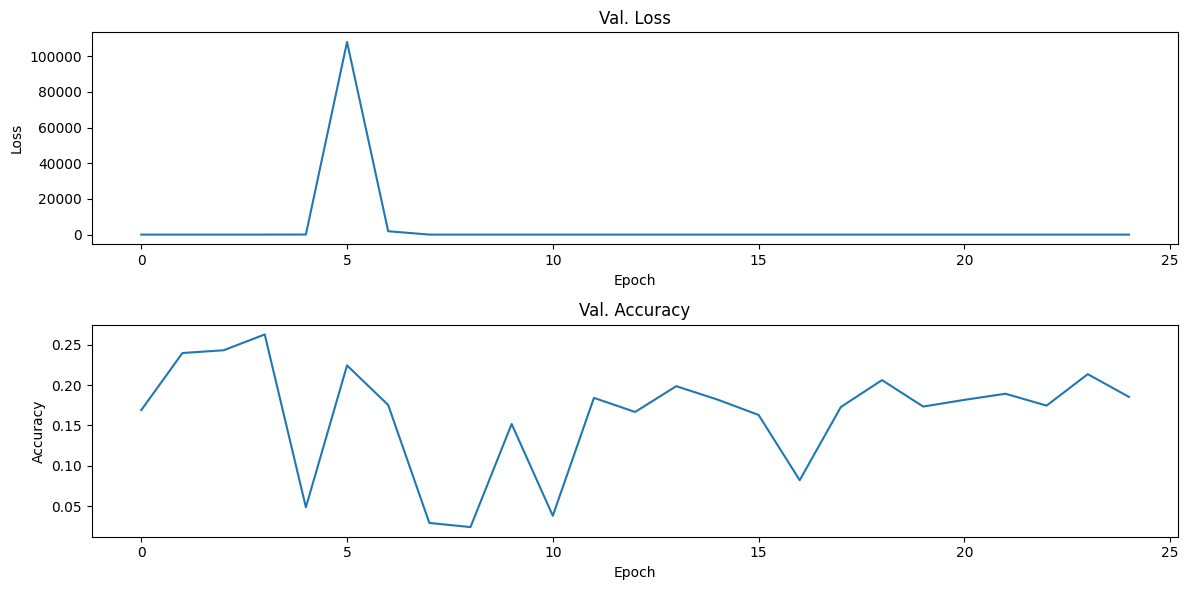

In [29]:
model_loss = model_history.history["val_loss"]
model_accuracy = model_history.history["val_accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(model_loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(model_accuracy)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

ACCURACY AND LOSS GRAPH (U-Net with spatial attention and VGG16)

In [30]:
model_history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

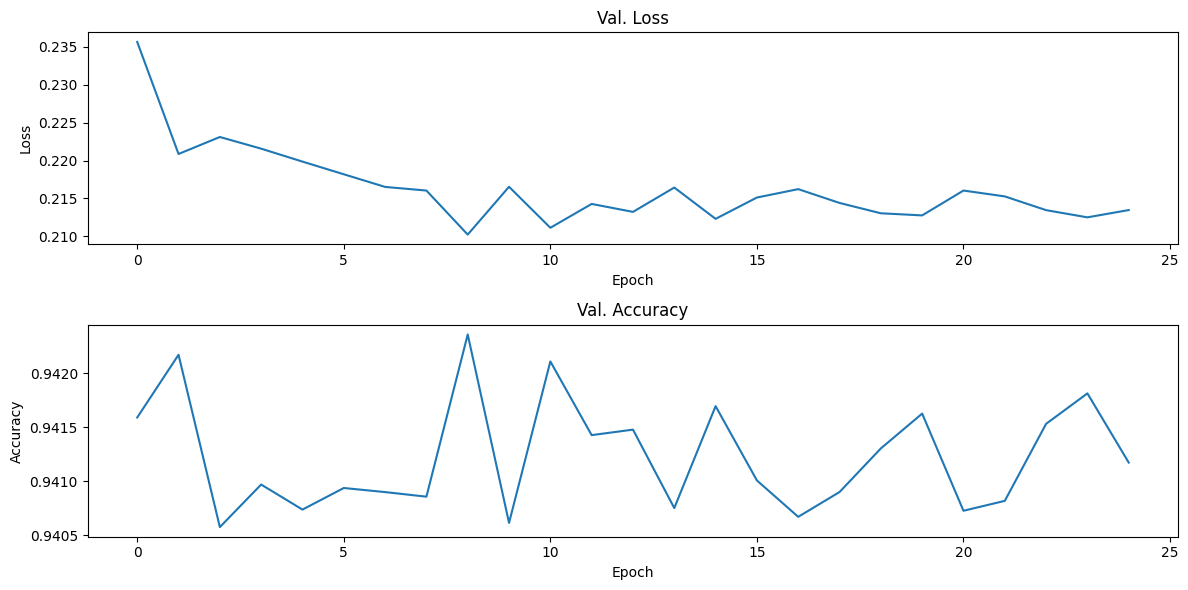

In [31]:
model_loss = model_history2.history["val_loss"]
model_accuracy = model_history2.history["val_accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(model_loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(model_accuracy)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

Comparing Both

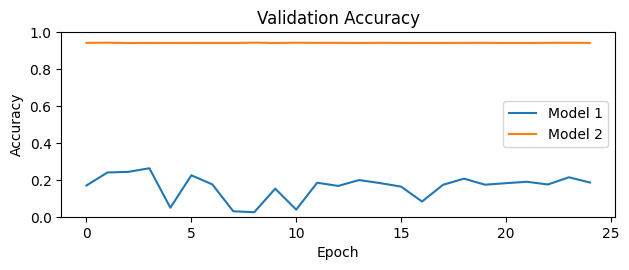

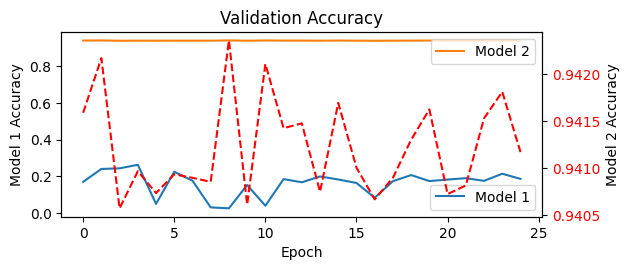

In [37]:
plt.subplot(212)
plt.title("Validation Accuracy")
line1, = plt.plot(model_history.history["val_accuracy"], label="Model 1")
line2, = plt.plot(model_history2.history["val_accuracy"], label="Model 2")
plt.xlabel("Epoch")
plt.ylabel("Model 1 Accuracy")
plt.legend(handles=[line1])

# Create a twin axis for Model 2 accuracy with a different y-axis label
ax2 = plt.twinx()
ax2.plot(model_history2.history["val_accuracy"], color='red', linestyle='--', label='Model 2')
ax2.set_ylabel('Model 2 Accuracy')
ax2.tick_params(axis='y', labelcolor='red')
plt.legend(handles=[line2])
plt.tight_layout()
plt.savefig("compare_models.png", dpi=150)
plt.show()


<h3>The Results</h3>

We can now visualize how the CNN performs at the example of a few validation images.

In [ ]:
test_generator = generate_data(val_img_path)
max_show=20
for test_input_imgs, test_segs in test_generator:
    p = model.predict(test_input_imgs)
    for i in range(p.shape[0]):
        print(p[i])
        if i > max_show:
            break
        _p = Layers2RGBImage(p[i])
        _s = Layers2RGBImage(test_segs[i])

        predimg = cv2.addWeighted(test_input_imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(test_input_imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_generator = generate_data(val_img_path, batch_size=200)
max_show=20

bass = []

for test_input_imgs, test_segs in test_generator:
    p = model.predict(test_input_imgs)

    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(test_segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())

        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(test_segs[:,:,:,i].ravel(), _p)

        bass.append(bas)

        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")

    plot.tight_layout()
    plot.show()

    break